In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, MultiHeadAttention, Conv1D,
    GlobalMaxPooling1D, GlobalAveragePooling1D, Dense, Concatenate
)
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the dataset
ds = load_dataset("carblacac/twitter-sentiment-analysis", trust_remote_code=True)

In [ ]:
# Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [ ]:
# Extract and preprocess data
X_train = [preprocess_text(text) for text in ds['train']['text'][:50000]]
y_train = np.array(ds['train']['feeling'][:50000])
X_test = [preprocess_text(text) for text in ds['test']['text'][:10000]]
y_test = np.array(ds['test']['feeling'][:10000])

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=200)
X_test_padded = pad_sequences(X_test_sequences, maxlen=200)

In [ ]:
# One-hot encode the labels
num_classes = 2
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

In [ ]:
# Fusion Model Architecture
input_layer = Input(shape=(200,))

# Shared embedding layer
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=200)(input_layer)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Transformer branch
attention_output = MultiHeadAttention(num_heads=8, key_dim=128)(embedding_layer, embedding_layer)
transformer_output = GlobalAveragePooling1D()(attention_output)


In [ ]:
# CNN branch
cnn_output = Conv1D(64, kernel_size=3, activation='relu')(embedding_layer)
cnn_output = GlobalMaxPooling1D()(cnn_output)


In [ ]:
# Combine Transformer and CNN outputs
fusion_output = Concatenate()([transformer_output, cnn_output])

In [ ]:
# Fully connected layers
dense_output = Dense(64, activation='relu')(fusion_output)
output_layer = Dense(num_classes, activation='softmax')(dense_output)

# Create the hybrid model
fusion_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
fusion_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
# Train the model
fusion_model.fit(
    X_train_padded, y_train_onehot,
    epochs=5, batch_size=64, validation_data=(X_test_padded, y_test_onehot)
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6920 - loss: 0.5656 - val_accuracy: 0.7733 - val_loss: 0.4731
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.8357 - loss: 0.3752 - val_accuracy: 0.7771 - val_loss: 0.4858
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9141 - loss: 0.2254 - val_accuracy: 0.7612 - val_loss: 0.5703
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9603 - loss: 0.1132 - val_accuracy: 0.7505 - val_loss: 0.7429
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.9790 - loss: 0.0606 - val_accuracy: 0.7522 - val_loss: 0.9580


In [ ]:
# Evaluate the model
loss, accuracy = fusion_model.evaluate(X_test_padded, y_test_onehot)
print(f"Test Accuracy: {accuracy:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7514 - loss: 0.9468
Test Accuracy: 0.752


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


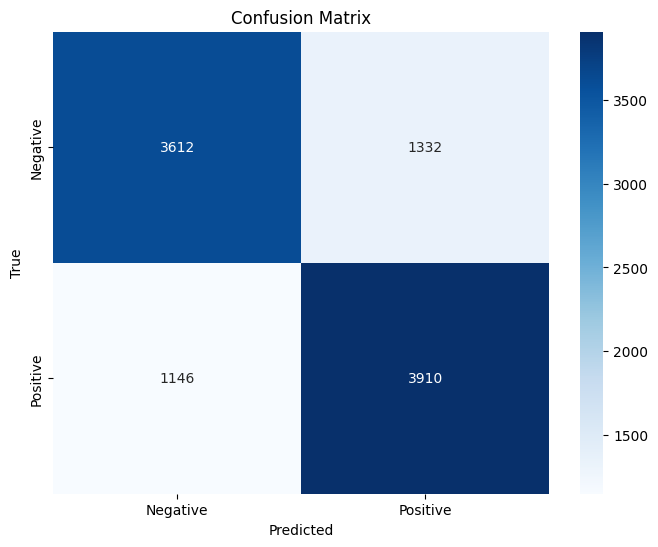

In [ ]:
# Confusion Matrix and Visualization
predictions = fusion_model.predict(X_test_padded)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()